In [17]:
from datascience import *
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## Classification

In [18]:
# Can you tell if a bank note is counterfeit or legitimate?
# Variables based on photgraphs of many banknotes (a few numbers for each image calculated)
banknotes = Table.read_table('banknote.csv')
banknotes

WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class
3.6216,8.6661,-2.8073,-0.44699,0
4.5459,8.1674,-2.4586,-1.4621,0
3.866,-2.6383,1.9242,0.10645,0
3.4566,9.5228,-4.0112,-3.5944,0
0.32924,-4.4552,4.5718,-0.9888,0
4.3684,9.6718,-3.9606,-3.1625,0
3.5912,3.0129,0.72888,0.56421,0
2.0922,-6.81,8.4636,-0.60216,0
3.2032,5.7588,-0.75345,-0.61251,0
1.5356,9.1772,-2.2718,-0.73535,0


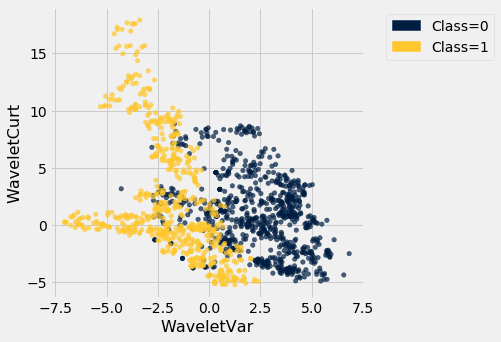

In [19]:
# Visualize 'WaveletVar' and 'WaveletCurt'
banknotes.scatter('WaveletVar', 'WaveletCurt', colors='Class')

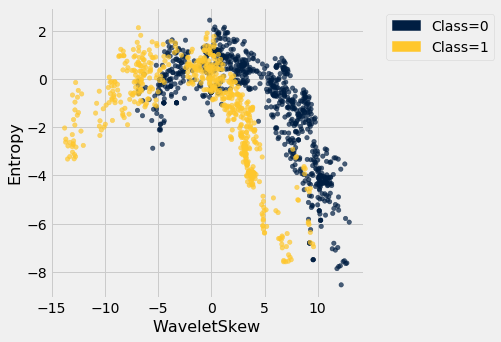

In [20]:
# Visualize 'WaveletSkew', 'Entropy'
banknotes.scatter('WaveletSkew', 'Entropy', colors='Class')

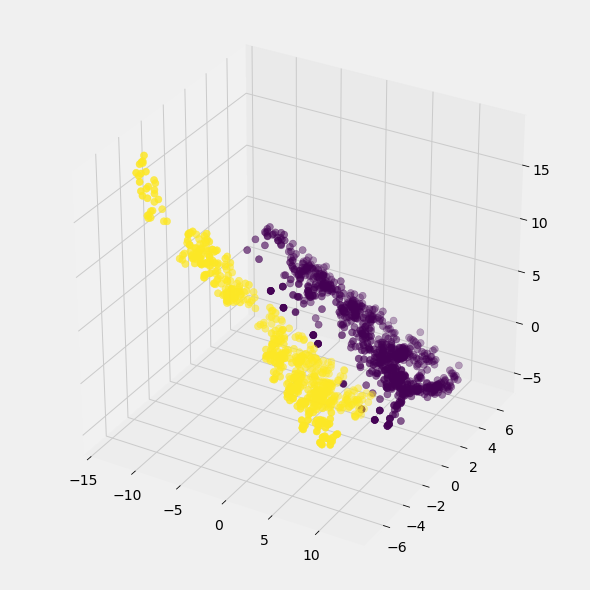

In [21]:
# Two attributes have some overlap of classes...what happens with three attributes?
fig = plots.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.scatter(banknotes.column('WaveletSkew'), 
           banknotes.column('WaveletVar'), 
           banknotes.column('WaveletCurt'), 
           c=banknotes.column('Class'),
           cmap='viridis',
          s=50);

## Breast cancer classifier

In [22]:
#Class 1 = malignant (cancer)
#Class 0 = benign (not cancer)
patients = Table.read_table('breast-cancer.csv').drop('ID')
patients.show(5)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,1,1,1,2,1,3,1,1,0
5,4,4,5,7,10,3,2,1,0
3,1,1,1,2,2,3,1,1,0
6,8,8,1,3,4,3,7,1,0
4,1,1,3,2,1,3,1,1,0


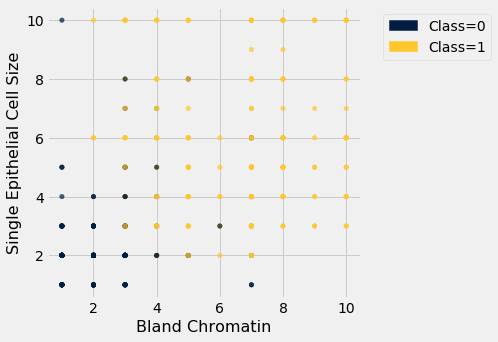

In [23]:
#A number of points are layered
patients.scatter('Bland Chromatin', 'Single Epithelial Cell Size', colors='Class')

In [53]:
#Function to "jitter" the points (for visualization purposes)
def randomize_column(a):
    return a + np.random.normal(0.0, 0.09, size=len(a))

jittered = Table().with_columns([
        'Bland Chromatin (jittered)', 
        randomize_column(patients.column('Bland Chromatin')),
        'Single Epithelial Cell Size (jittered)', 
        randomize_column(patients.column('Single Epithelial Cell Size')),
        'Class',
        patients.column('Class')
    ])


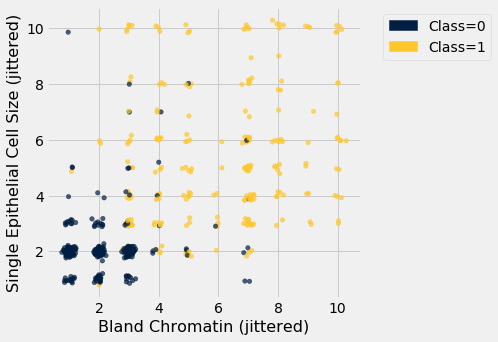

In [54]:
# Plot the data with the points jittered
jittered.scatter(0, 1, colors='Class')

## Distance

In [25]:
# Get only features of the data (i.e. the attributes) without the class labels
features = patients.drop('Class')
features.show(3)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
5,1,1,1,2,1,3,1,1
5,4,4,5,7,10,3,2,1
3,1,1,1,2,2,3,1,1


In [26]:
# create a function to compute the distance between two arrays
def distance(pt1, pt2):
    """Return the distance between two points, represented as arrays"""
    return np.sqrt(sum((pt1 - pt2)**2))

In [27]:
# We can use np.array(tuple(row)) convert a row to an numpy array
row_one_array = np.array(tuple(features.row(1)))
row_one_array

array([ 5,  4,  4,  5,  7, 10,  3,  2,  1])

In [28]:
# create a function to compute the distance between two rows in a Table
def row_distance(row1, row2):
    """Return the distance between two numerical rows of a table"""
    return distance(np.array(tuple(row1)), np.array(tuple(row2)))

In [29]:
# distance between the first and second row
row_distance(features.row(0), features.row(1))

11.874342087037917

In [30]:
# sanity check: distance between first row and itself
row_distance(features.row(0), features.row(0))

0.0

## Classification Procedure ##

In [31]:
# a function to compute the distance between a whole training set and a given example
# returns the training set with an additional column that has the distance to the example for each row
def distances(training, example):
    """Compute distance between example and every row in training.
    Return training augmented with Distance column"""
    distances = make_array()
    attributes = training.drop('Class')
    for row in attributes.rows:
        distances = np.append(distances, row_distance(row, example))
    return training.with_column('Distance', distances)

In [32]:
# Let's look at patient 15
patients.take(15)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
7,4,6,4,6,1,4,3,1,1


In [33]:
# Let's look at the features for row 15
example = features.row(15)
example

Row(Clump Thickness=7, Uniformity of Cell Size=4, Uniformity of Cell Shape=6, Marginal Adhesion=4, Single Epithelial Cell Size=6, Bare Nuclei=1, Bland Chromatin=4, Normal Nucleoli=3, Mitoses=1)

In [34]:
# Let's look at the distance between patient 15 and all other patients
distances(patients.exclude(15), example).sort('Distance')

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,Distance
8,4,6,3,3,1,4,3,1,0,3.31662
5,3,4,1,4,1,3,1,1,0,5.19615
5,4,5,1,8,1,3,6,1,0,5.2915
8,2,4,1,5,1,5,4,4,1,5.47723
9,5,5,4,4,5,4,3,3,1,5.47723
6,3,3,3,3,2,6,1,1,0,5.47723
9,5,5,2,2,2,5,1,1,1,5.65685
3,4,5,3,7,3,4,6,1,0,5.65685
5,3,3,2,3,1,3,1,1,0,5.65685
5,6,5,6,10,1,3,1,1,1,5.83095


In [35]:
# A function that will return a table with the k closest distances to an example
def closest(training, example, k):
    """Return a table of the k closest neighbors to example"""
    return distances(training, example).sort('Distance').take(np.arange(k))

In [36]:
# Applying the closest function to example patient 15
closest_table = closest(patients.exclude(15), example, 5)
closest_table 

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,Distance
8,4,6,3,3,1,4,3,1,0,3.31662
5,3,4,1,4,1,3,1,1,0,5.19615
5,4,5,1,8,1,3,6,1,0,5.2915
8,2,4,1,5,1,5,4,4,1,5.47723
9,5,5,4,4,5,4,3,3,1,5.47723


In [37]:
# A function that returns the class label for the class that has the most nearest neighbors
def majority_class(topk):
    """Return the class with the highest count"""
    return topk.group('Class').sort('count', descending=True).column(0).item(0)

majority_class(closest_table) 

0

In [38]:
# The full k nearest neighbor classification function
def classify(training, example, k):
    "Return the majority class among the k nearest neighbors of example"
    return majority_class(closest(training, example, k))

In [39]:
# applying the kNN function to patient 15
classify(patients.exclude(15), example, 5)

0

In [40]:
# Let's look at patient 15 - did we make the correct prediction? 
patients.take(15)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
7,4,6,4,6,1,4,3,1,1


In [41]:
# Let's try it for patient 10
new_example = features.row(10)
classify(patients.exclude(10), new_example, 5)

0

In [42]:
# Did we get it correct?
patients.take(10)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
1,1,1,1,1,1,3,1,1,0


In [43]:
# evaluate any patient number...
patient_to_use = 6
new_example = features.row(patient_to_use)
classify(patients.exclude(patient_to_use), new_example, 5), patients.take(patient_to_use).column("Class").item(0)

(0, 0)

## Evaluation ##

In [44]:
# Show the total number of rows in the data set
patients.num_rows

683

In [45]:
# Create a training and test set
shuffled = patients.sample(with_replacement=False) # Randomly permute the rows
training_set = shuffled.take(np.arange(342))
test_set  = shuffled.take(np.arange(342, 683))

In [46]:
# print the number of points in the training and test set
print(training_set.num_rows)
print(test_set.num_rows)

342
341


In [47]:
# create a function that returns the proportion of points correctly classified in the test set
def evaluate_accuracy(training, test, k):
    """Return the proportion of correctly classified examples 
    in the test set"""
    test_attributes = test.drop('Class')
    num_correct = 0
    for i in np.arange(test.num_rows):
        c = classify(training, test_attributes.row(i), k)
        num_correct = num_correct + (c == test.column('Class').item(i))
    return num_correct / test.num_rows

In [48]:
# evaluate the classifier using k = 5
evaluate_accuracy(training_set, test_set, 5)

0.9648093841642229

In [49]:
# evaluate the classifier using k = 3
evaluate_accuracy(training_set, test_set, 3)

0.9589442815249267

In [50]:
# evaluate the classifier using k = 11
evaluate_accuracy(training_set, test_set, 11)

0.9472140762463344

In [51]:
# evaluate the classifier using k = 1 both training and testing using only the training set
evaluate_accuracy(training_set, training_set, 1)

1.0

In [52]:
# evaluate the classifier using k = 1
evaluate_accuracy(training_set, test_set, 1)

0.9501466275659824